In [1]:
from PYME.IO.image import ImageStack
from double_helix.DoubleGaussFit import Detector as new_detector
from double_helix.FitFactories.DoubleHelixFit_Theta import Detector as old_detector
import matplotlib.pyplot as plt
from scipy import ndimage
# %matplotlib widget
# plt.set_loglevel("warning")
import numpy as np
import os
from PYME.recipes.processing import BackgroundSubtractionMovingPercentile

In [28]:
im = ImageStack(filename = "E:/Toxoplasma_Fixed_Cell_Imaging/20241219_MyoH_ALFA_Gels/P2S6/FOV9_647.h5", haveGUI=False)
im.mdh['Camera.NoiseFactor'] = 1.4 # typical for EMCCD with gain > 10
im.mdh['Camera.ElectronsPerCount'] = 12.9  # e-/ADU
im.mdh['Camera.TrueEMGain'] = 272
im.mdh['Camera.ADOffset'] = 110 # [ADU]
im.mdh['voxelsize.x'] = 0.1224 # [um]
im.mdh['voxelsize.y'] = 0.1224 # [um]
im.mdh['Camera.ReadNoise']

filename == E:\Toxoplasma_Fixed_Cell_Imaging\20241219_MyoH_ALFA_Gels\P2S6\FOV9_647.h5
E:\Toxoplasma_Fixed_Cell_Imaging\20241219_MyoH_ALFA_Gels\analysis\P2S6\FOV9_647.h5r


52.2

In [29]:
bg_sub = BackgroundSubtractionMovingPercentile().apply_simple(im)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002116EBAA9C8>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002116F1AA188>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002116F224BC8>


8
16


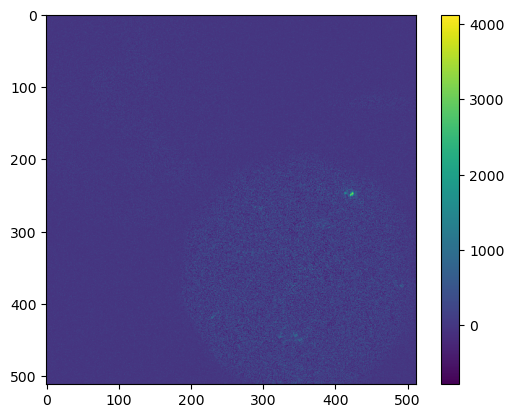

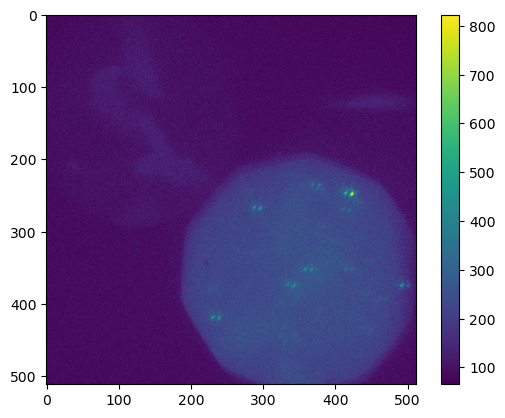

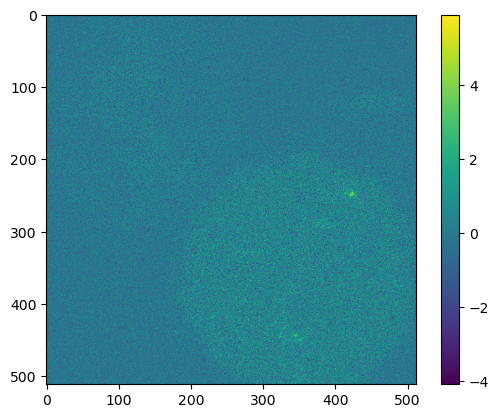

In [30]:
from PYME.localization.remFitBuf import fitTask

frame_num = 11547

test_frame = np.squeeze(im.data_xytc[:,:,frame_num,0])
bg_subbed_frame = np.squeeze(bg_sub.data_xytc[:,:,frame_num,0])

# test_frame[test_frame<0] = 0
# bg_subbed_frame[bg_subbed_frame<0] = 0

plt.figure()
plt.imshow(bg_subbed_frame)
plt.colorbar()


sigma = np.squeeze(fitTask.calcSigma(im.mdh, test_frame.astype('f')))
plt.figure()
plt.imshow(sigma)
plt.colorbar()

plt.figure()
plt.imshow(bg_subbed_frame/sigma)
plt.colorbar()

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x0000021170244B08>


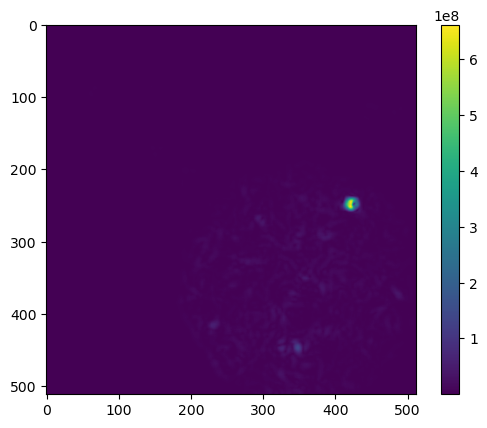

In [31]:

# plt.figure()
# plt.imshow(im.data_xytc[:,:,test_frame,0])
# plt.colorbar()

detector_old = old_detector(roi_half_size=10, mag=0.15)


strength_image_old, angle_image_old = detector_old.filter_frame(bg_subbed_frame)

plt.figure()
plt.imshow(strength_image_old)
plt.colorbar()

Optimization terminated successfully.
         Current function value: -0.012159
         Iterations: 15
         Function evaluations: 30


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002116FEB0248>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002116FA4FD08>


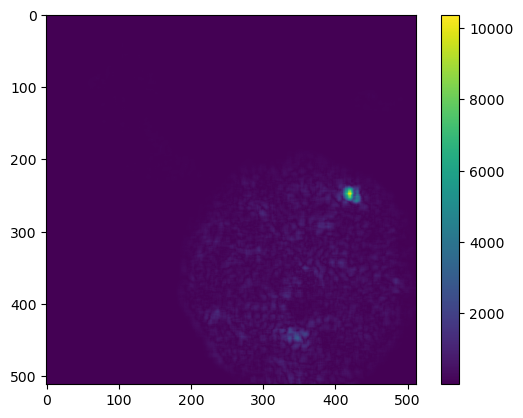

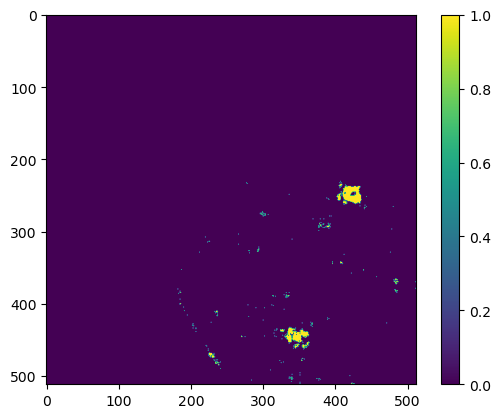

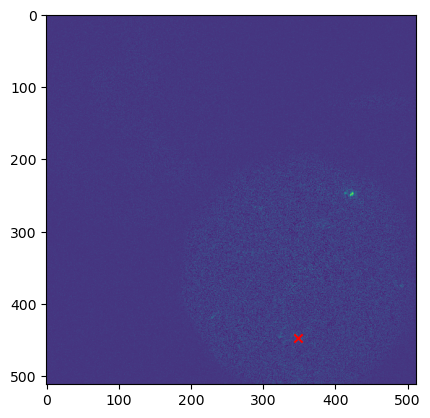

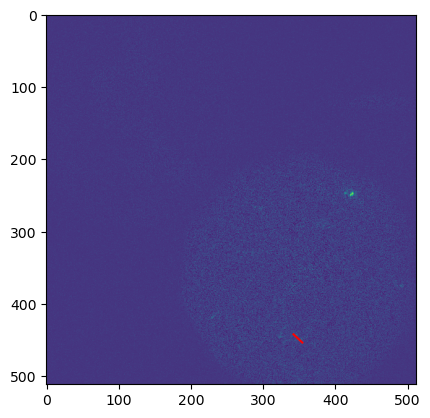

In [33]:
detector_new = new_detector(roi_half_size=10, l_initial=1025, lobe_sigma_initial=197, filter_sigma=8, px_size_nm=122.4)

strength_image_new, angle_image_new = detector_new.filter_frame(bg_subbed_frame)

plt.figure()
plt.imshow(strength_image_new)
plt.colorbar()

thresh = 1.2



plt.figure()
plt.imshow(strength_image_new>(thresh * sigma)**2 * detector_new.normFactor)
# plt.imshow(strength_image_new> thresh)
plt.colorbar()

row, col, orientation = detector_new.extract_candidates(strength_image_new, angle_image_new, (thresh * sigma)**2 * detector_new.normFactor)
# row, col, orientation = detector_new.extract_candidates(strength_image_new, angle_image_new, thresh)

def lobe_estimate_from_center_pixel(x_pix, y_pix, orientation, lobe_sep_px):
    dx = np.cos(orientation) * lobe_sep_px
    dy = np.sin(orientation) * lobe_sep_px
    x1 = x_pix - dx
    y1 = y_pix - dy
    x2 = x_pix + dx
    y2 = y_pix + dy
    return x1, y1, x2, y2

x1, y1, x2, y2 = lobe_estimate_from_center_pixel(col, row, orientation, 1025/122.4)

plt.figure()
plt.imshow(bg_subbed_frame)
plt.scatter(col, row, marker='x', c='red')

plt.figure()
plt.imshow(bg_subbed_frame)
for ii in range(len(row)):
    plt.plot([x1, x2], [y1, y2], 'r')

plt.show()

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002116FAACFC8>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x0000021173C9FE08>


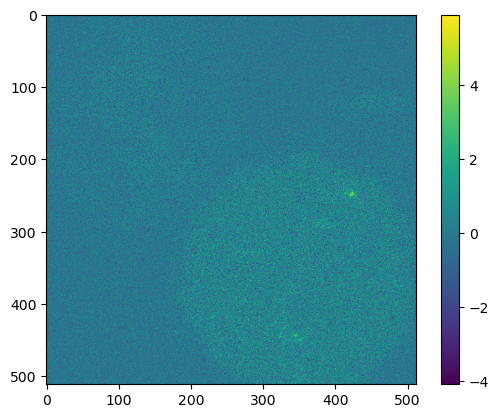

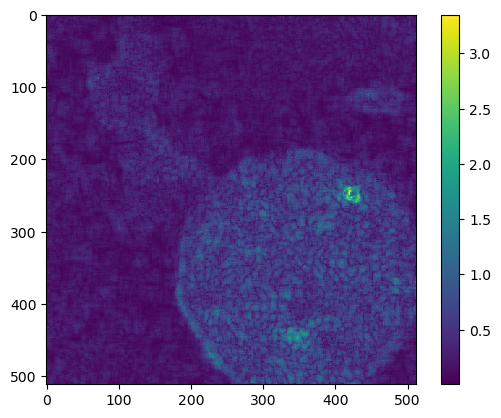

In [34]:
plt.figure()
plt.imshow(bg_subbed_frame/sigma)
plt.colorbar()

plt.figure()
plt.imshow(np.sqrt(strength_image_new/(detector_new.normFactor*sigma**2)), interpolation='nearest')
plt.colorbar()

In [8]:
np.shape((thresh * sigma)**2 * detector_new.normFactor)

(512, 512)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x0000021171315C08>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000211713AAAC8>


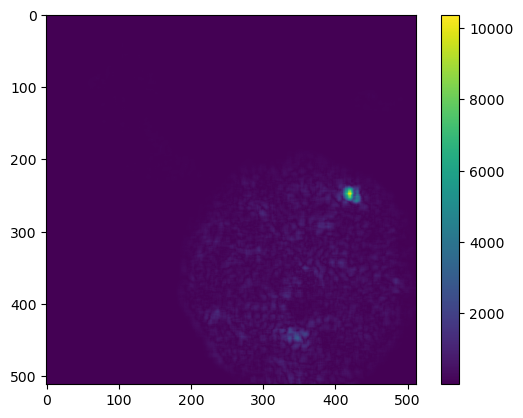

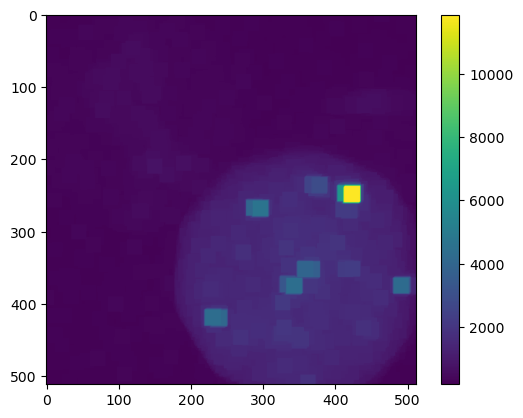

In [35]:

plt.figure()
plt.imshow(strength_image_new)
plt.colorbar()

plt.figure()
plt.imshow(detector_new.max_filtered_threshold)
plt.colorbar()